In [3]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys
sys.path.insert(1, 'utils') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:50:38) 
[Clang 11.1.0 ]
Virtual memory usage - total: 16 GB / available: 8 GB / percent used: 48.0 %


In [5]:
ds = xr.open_dataset('../MARgrid_EUf.nc')
ds # ds as dataset

<xarray.Dataset>
Dimensions:  (y: 126, x: 201)
Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
Data variables:
    LAT      (y, x) float32 ...
    LON      (y, x) float32 ...
    MSK      (y, x) float32 ...
    SH       (y, x) float32 ...
    SRF      (y, x) float32 ...
Attributes:
    title:        ICE - Exp: f08 - 20100101
    institution:  ULg (Xavier Fettweis)
    history:      Mon Apr 20 11:53:57 2020: ncks -v LON,LAT,SH,SRF,MSK ICE.ER...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          "4.6.3"

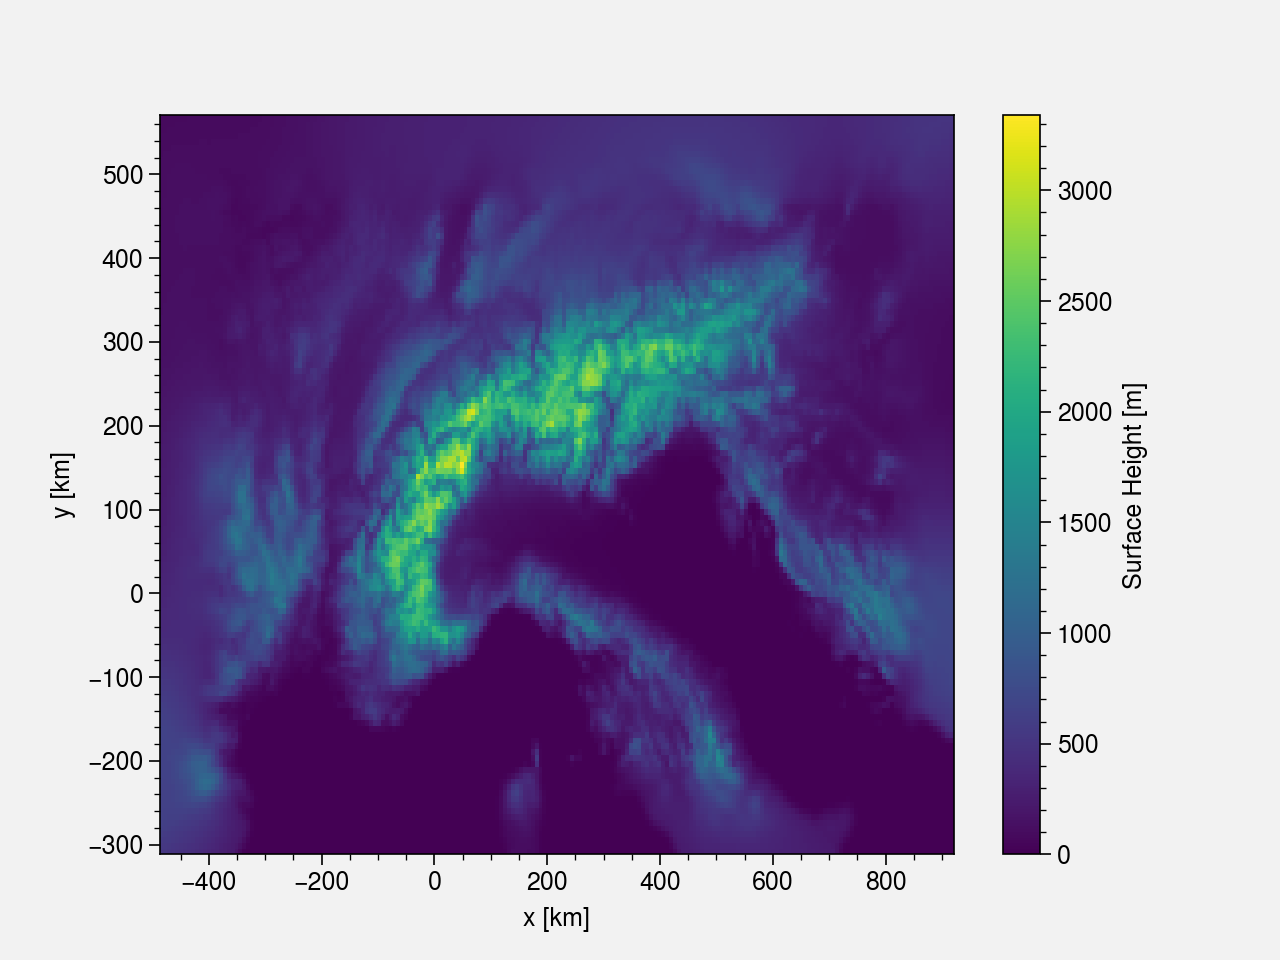

In [6]:
ds.SH.plot()

Text(0.5, 1.0, 'Topography with a 7km resolution')

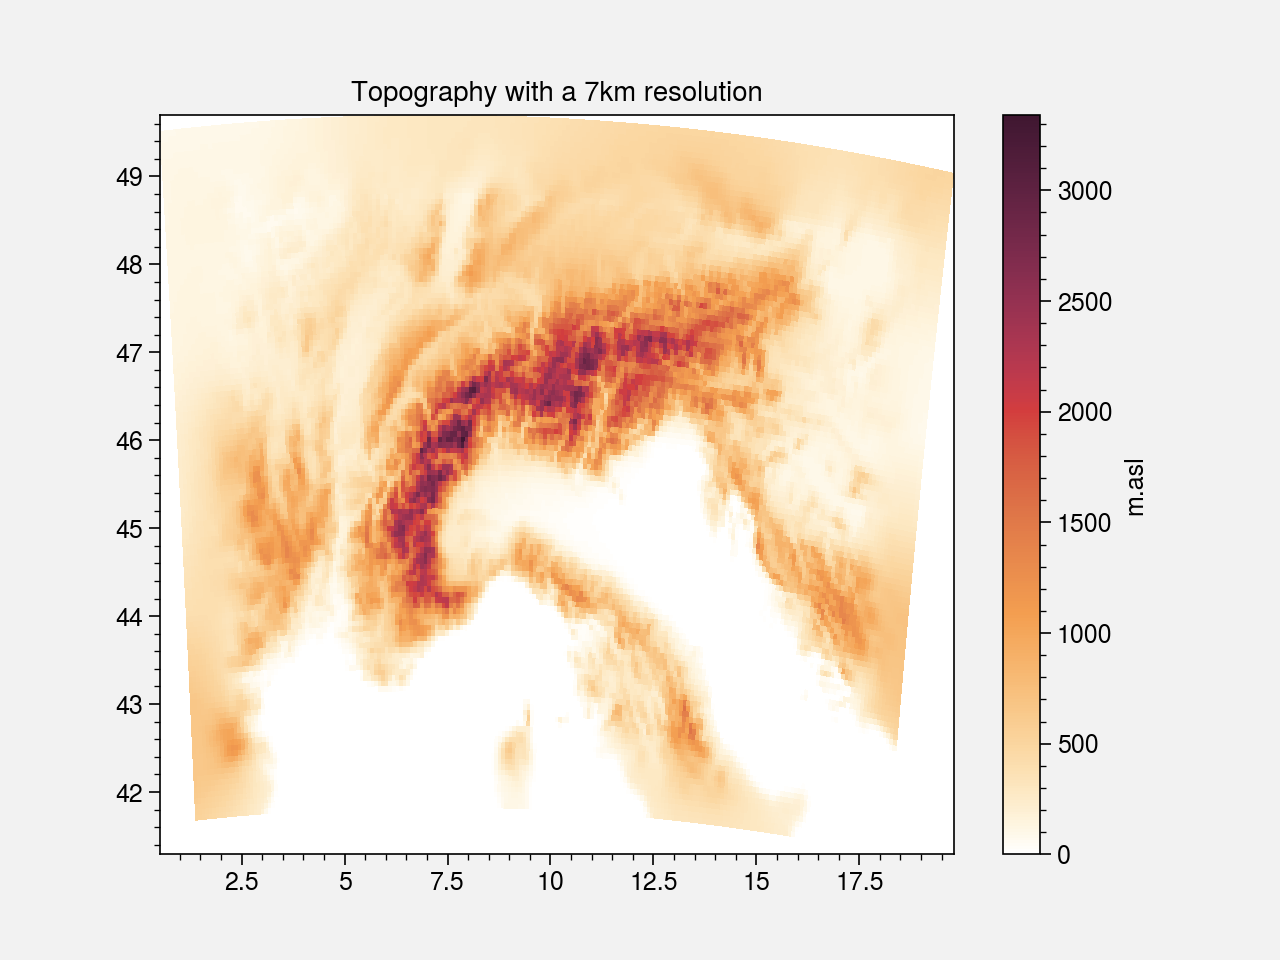

In [46]:
fig, ax = plt.subplots()
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH)
fig.colorbar(m,label= 'm.asl')
ax.set_title('Topography with a 7km resolution')

In [30]:
ds_T = xr.open_dataset('../MAR_ERA20C_TTz.nc')
ds_T # ds as dataset

<xarray.Dataset>
Dimensions:    (x: 201, y: 126, ztqlev: 4, time: 1308, bnds: 2)
Coordinates:
  * x          (x) float32 -483.0 -476.0 -469.0 -462.0 ... 903.0 910.0 917.0
  * y          (y) float32 -308.0 -301.0 -294.0 -287.0 ... 553.0 560.0 567.0
  * ztqlev     (ztqlev) float32 2.0 10.0 50.0 100.0
  * time       (time) datetime64[ns] 1902-01-16T12:00:00 ... 2010-12-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    TTz        (time, ztqlev, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    history:      Wed Jan 12 15:26:24 2022: ncrcat /bettik/beaumetj/MARout/MA...
    institution:  ULg (Xavier Fettweis)
    title:        ICE - Exp: f23 - 19020101
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          netCDF Operators version 4.8.1 (Homepage = http://nco.sf.ne...
    frequency:    mon
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/...

In [32]:
ds_T.coords

Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
  * time     (time) datetime64[ns] 1902-01-16T12:00:00 ... 2010-12-16T12:00:00

In [33]:
ds_T.TTz.shape

(1308, 4, 126, 201)

In [34]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")


In [39]:
seasonal_mean=season_mean(ds_T.TTz[:,0,:,:])

In [40]:
seasonal_mean.shape

(4, 126, 201)

In [41]:
season_names=['DJF','MAM','JJA','SON']

i=0
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1782f13b0> >
i=1
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1782f14a0> >
i=2
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1782f1540> >
i=3
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1782f15e0> >


/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'large' was renamed to text.titlesize in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.alpha' was renamed to grid.alpha in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in versi

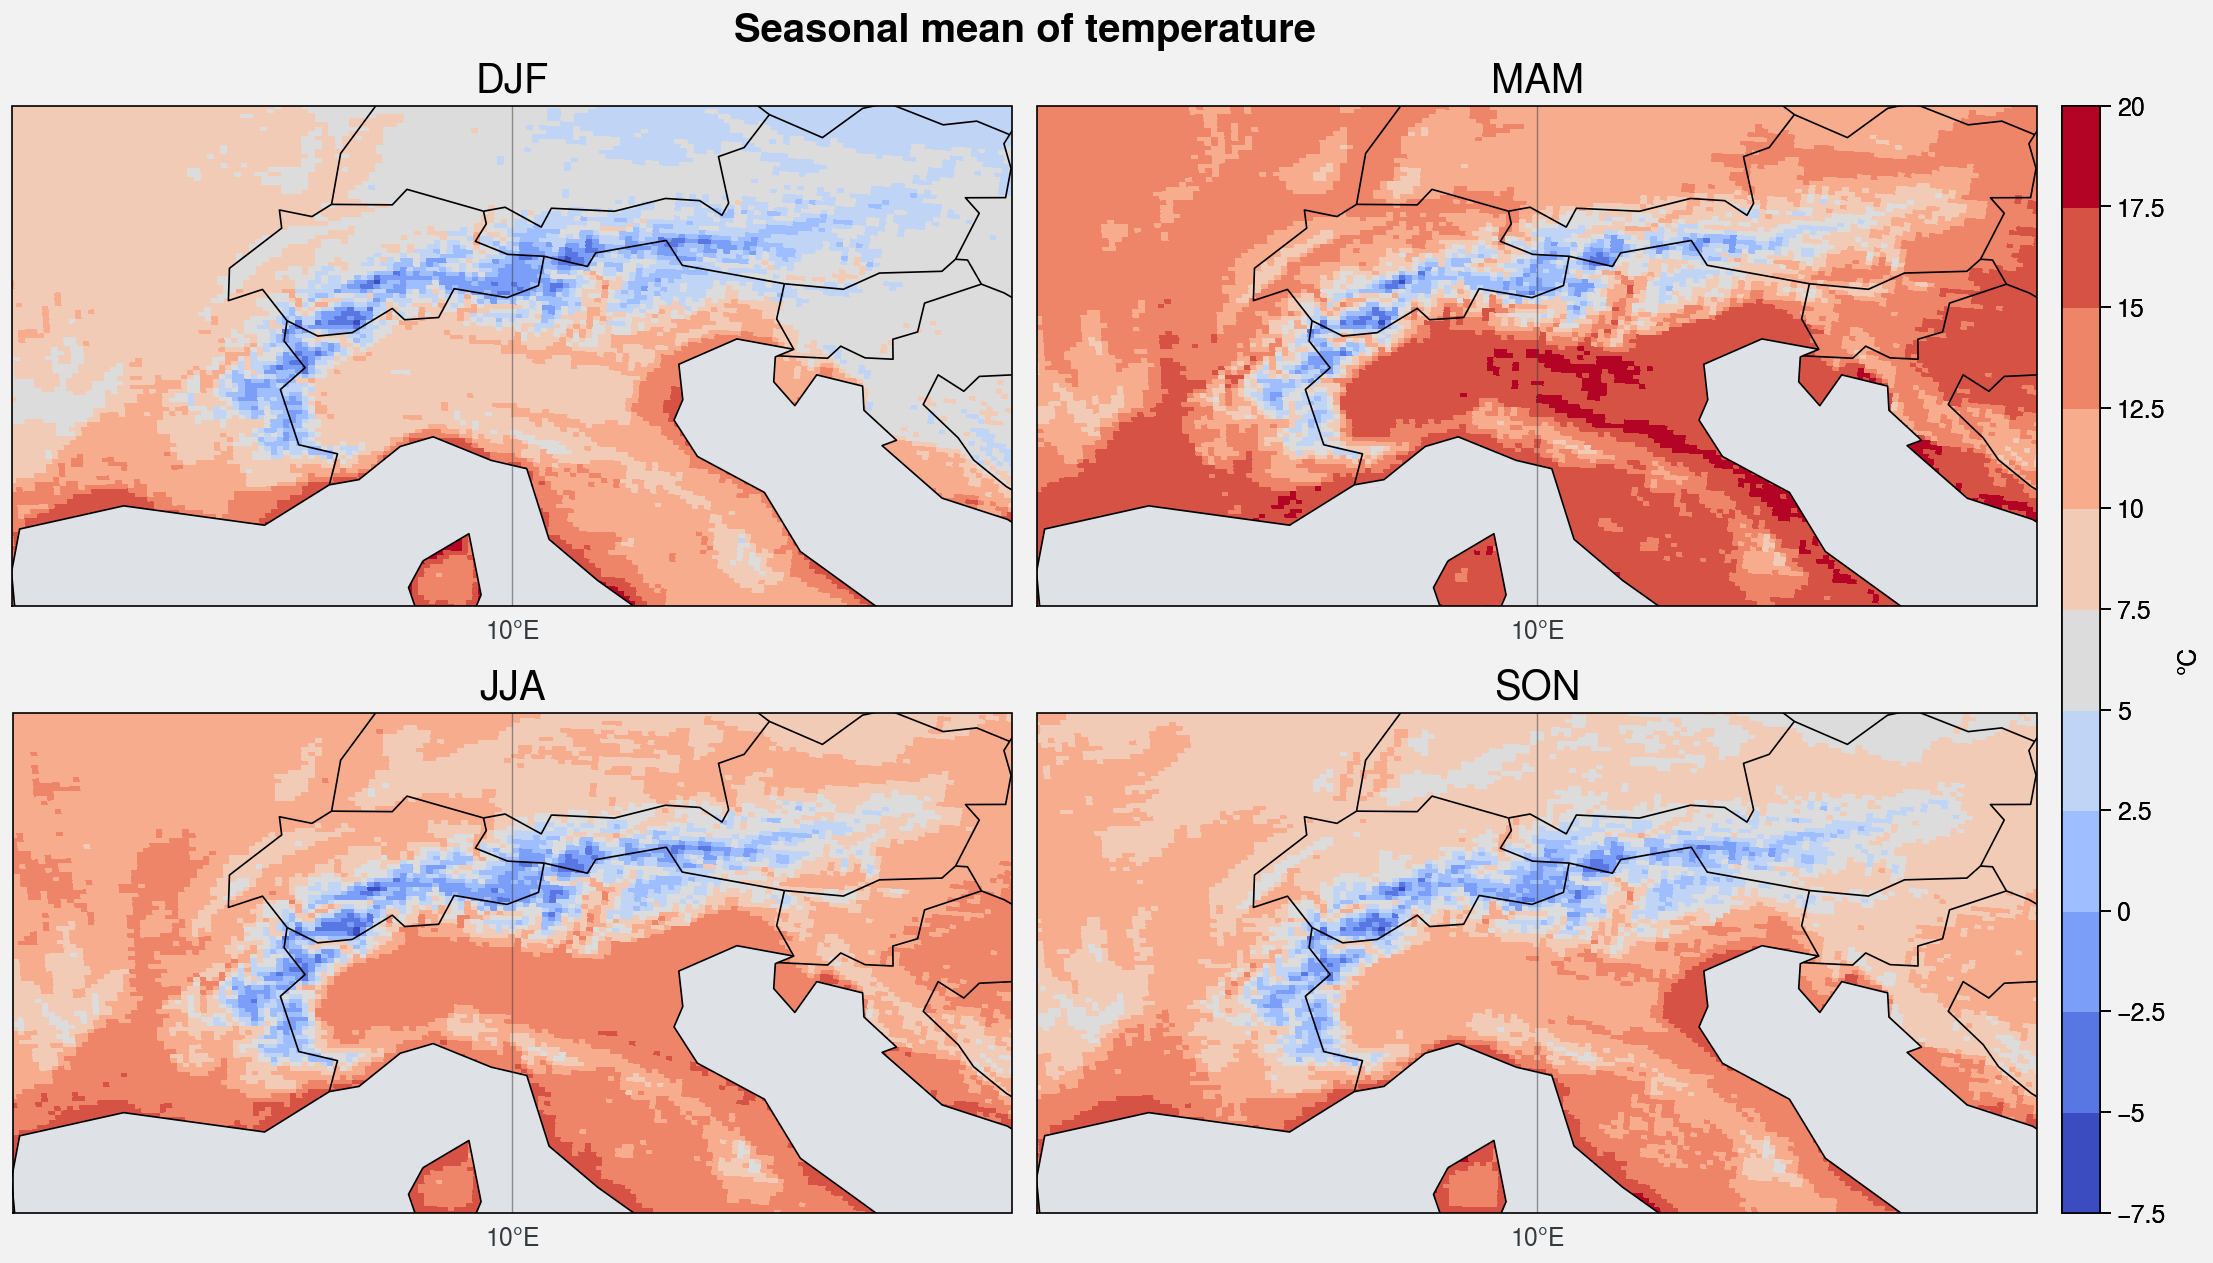

In [85]:
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)

for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds.LON,ds.LAT,
        seasonal_mean[i,:,:],
#        levels=levels,
        cmap='coolwarm'
    )
    ax.format(title=season_names[i],large='20px')
    
f.colorbar(m, label= '°C')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Seasonal mean of temperature",
    lonlines=10, latlines=10, abc=False, latlim=[42,49],lonlim=[3,17]
)